# Human Activity Recognition

## Setting up the environment

In [1]:
import os
import re
import numpy as np
import pandas as pd
import math
import statistics as st
import itertools

from scipy import stats
from statsmodels import robust

import warnings
warnings.filterwarnings('ignore')

## Functions for Statistical Calculations

In [2]:
def correlation(data1, data2):
    corr, p = stats.pearsonr(data1, data2)
    if math.isnan(corr):
        return 0
    else:
        return corr

def sma(x, y, z):
    sum_ = 0
    X = list(x)
    Y = list(y)
    Z = list(z)
    for i in range(len(X)):
        sum_ += abs(X[i]) + abs(Y[i]) + abs(Z[i])
    return sum_ / len(X)

def calc_entropy(data):
    entropy = stats.entropy(data, base=2)
    if math.isinf(entropy) or math.isnan(entropy):
        return -1
    else:
        return entropy

def energy(data):
    sum_ = 0
    for d in data:
        sum_ += d ** 2
        
    return sum_ / len(data)

def iqr(data):
    return np.subtract(*np.percentile(data, [75, 25]))

## Function for reading the Datasets

In [3]:
def read_dataset(dirName):
    print("Reading Raw Data...")
    raw_datasets = []
    raw_datalabels = []

    for filename in os.listdir(dirName):
        if filename.endswith(".csv"):
            raw = pd.read_csv(os.path.join(dirName, filename))
            cols = raw.columns
            cols = cols.str.replace('([\(\[]).*?([\)\]])', '')
            cols = cols.str.replace('\s','_')
            raw.columns = cols
            to_drop = []
            for col in raw.columns:
                if not ("_X_" in col or "_Y_" in col or "_Z_" in col):
                    to_drop.append(col)
            raw = raw.drop(to_drop, axis=1)
            column_names = raw.columns
            raw = raw.drop_duplicates(keep='last')
            raw_datasets.append(raw)
            raw_datalabels.append(filename.split(".")[0])
            
    return raw_datasets, raw_datalabels, column_names

## Function for Processing Raw Data

In [4]:
def process_raw_data(raw_datasets, raw_datalabels, column_names):
    print("Processing Data...")
    datasets = dict()
    statistics = ["mean", "mad", "max", "min", "std", "energy", "iqr", "entropy"]
    diff_col_names = []
    for col in range(0,len(column_names),3):
        diff_col_names.append(column_names[col][:len(column_names[col])-3])

    for col in column_names:
        for stat in statistics:
            key = col + "~" + stat
            datasets[key] = []

    for col in diff_col_names:
        datasets[col+"_XY_~correlation"] = []
        datasets[col+"_YZ_~correlation"] = []
        datasets[col+"_ZX_~correlation"] = []
        datasets[col+"_XYZ_~sma"] = []

    datasets["Activity"] = []

    for ind,raw_data in enumerate(raw_datasets):
        for d in range(0, len(raw_data), 5):
            if d+5 < len(raw_data):
                data = raw_data[d:d+5]
            else:
                break
            for c in diff_col_names:
                col_X = c + "_X_"
                col_Y = c + "_Y_"
                col_Z = c + "_Z_"

                datasets[col_X+"~mean"].append(st.mean(data[col_X])) # mean X
                datasets[col_Y+"~mean"].append(st.mean(data[col_Y])) # mean Y
                datasets[col_Z+"~mean"].append(st.mean(data[col_Z])) # mean Z

                datasets[col_X+"~mad"].append(robust.mad(np.array(data[col_X]))) # median absolute deviation X
                datasets[col_Y+"~mad"].append(robust.mad(np.array(data[col_Y]))) # median absolute deviation Y
                datasets[col_Z+"~mad"].append(robust.mad(np.array(data[col_Z]))) # median absolute deviation Z

                datasets[col_X+"~max"].append(max(data[col_X])) # maximum X
                datasets[col_Y+"~max"].append(max(data[col_Y])) # maximum Y
                datasets[col_Z+"~max"].append(max(data[col_Z])) # maximum Z

                datasets[col_X+"~min"].append(min(data[col_X])) # minimum X
                datasets[col_Y+"~min"].append(min(data[col_Y])) # minimum Y
                datasets[col_Z+"~min"].append(min(data[col_Z])) # minimum Z

                datasets[col_X+"~std"].append(st.stdev(data[col_X])) # standard deviation X
                datasets[col_Y+"~std"].append(st.stdev(data[col_Y])) # standard deviation Y
                datasets[col_Z+"~std"].append(st.stdev(data[col_Z])) # standard deviation Z

                datasets[col_X+"~energy"].append(energy(data[col_X])) # energy X
                datasets[col_Y+"~energy"].append(energy(data[col_Y])) # energy Y
                datasets[col_Z+"~energy"].append(energy(data[col_Z])) # energy Z

                datasets[col_X+"~iqr"].append(iqr(data[col_X])) # interquartile range X
                datasets[col_Y+"~iqr"].append(iqr(data[col_Y])) # interquartile range Y
                datasets[col_Z+"~iqr"].append(iqr(data[col_Z])) # interquartile range Z

                datasets[col_X+"~entropy"].append(calc_entropy(data[col_X])) # entropy X
                datasets[col_Y+"~entropy"].append(calc_entropy(data[col_Y])) # entropy Y
                datasets[col_Z+"~entropy"].append(calc_entropy(data[col_Z])) # entropy Z

                datasets[c+"_XY_~correlation"].append(correlation(data[col_X], data[col_Y])) # correlation between X and Y
                datasets[c+"_YZ_~correlation"].append(correlation(data[col_Y], data[col_Z])) # correlation between Y and Z
                datasets[c+"_ZX_~correlation"].append(correlation(data[col_Z], data[col_X])) # correlation between Z and X


                datasets[c+"_XYZ_~sma"].append(sma(data[col_X], data[col_Y], data[col_Z]))

            datasets["Activity"].append(raw_datalabels[ind])
            data = []
        print(raw_datalabels[ind]," collected")
    print("Done")
    return datasets

## Processing Our Version of the Original

In [5]:
og_raw_dataset, og_raw_datalabels, og_column_names = read_dataset("OriginalRawDataSet")
original_dataset = process_raw_data(og_raw_dataset, og_raw_datalabels, og_column_names)
df = pd.DataFrame.from_dict(original_dataset, orient="columns")
df.to_csv("Processed_DataSet/OriginalProcessedData.csv",index=False)
print("Saved to OriginalProcessedData.csv")

Reading Raw Data...
Processing Data...
Laying  collected
Sitting  collected
Standing  collected
Walking  collected
WalkingDownstairs  collected
WalkingUpstairs  collected
Done
Saved to OriginalProcessedData.csv


## Processing Our New DataSet

In [6]:
new_raw_dataset, new_raw_datalabels, new_column_names = read_dataset("NewRawDataSet")
new_dataset = process_raw_data(new_raw_dataset, new_raw_datalabels, new_column_names)
df = pd.DataFrame.from_dict(new_dataset, orient="columns")
df.to_csv("Processed_DataSet/NewProcessedData.csv",index=False)
print("Saved to OriginalProcessedData.csv")

Reading Raw Data...
Processing Data...
Cycling  collected
Football  collected
JumpRope  collected
Pushups  collected
Swimming  collected
Tennis  collected
Done
Saved to OriginalProcessedData.csv


## Function for Splitting up Data

In [7]:
def split_data(processed_file, test_size=0.3):
    processed = pd.read_csv("Processed_DataSet/"+processed_file)

    print("No of NAN in processed: {}".format(processed.isnull().values.sum()))
    print("No of duplicates in processed: {}".format(sum(processed.duplicated())))

    train, test = train_test_split(processed, test_size=test_size, shuffle=True)

    y_train = train.Activity
    X_train = train.drop(['Activity'], axis=1)
    y_test = test.Activity
    X_test = test.drop(['Activity'], axis=1)
    
    return X_train, y_train, X_test, y_test

# Data Analysis

## Setting up environment

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

## Reading and Splitting Data

In [9]:
print("Obtaining Original Processed Data")
og_X_train, og_y_train, og_X_test, og_y_test = split_data("OriginalProcessedData.csv")
og_labels = ['Sitting', 'Standing','Walking', 'WalkingDownStairs', 'WalkingUpStairs', 'Laying']

print("\nObtaining New Processed Data")
new_X_train, new_y_train, new_X_test, new_y_test = split_data("NewProcessedData.csv")
new_labels = ['Cycling', 'Football', 'Swimming', 'Tennis', 'Pushups', 'JumpRope']

Obtaining Original Processed Data
No of NAN in processed: 0
No of duplicates in processed: 0

Obtaining New Processed Data
No of NAN in processed: 0
No of duplicates in processed: 0


## Apply t-sne on the data

In [10]:
# performs t-sne with different perplexity values and their repective plots

def perform_tsne(X_data, y_data, perplexities, markers, n_iter=1000):
    
    for index, perplexity in enumerate(perplexities):
        # perform t-sne
        print("\nPerforming tsne with perplexity {} and with {} iterations at max".format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')
        
        # prepare data for seaborn
        print("Creating plot for this t-sne visualization")
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1], 'label':y_data})
        
        # draw the plot in appropriate palce in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8, palette="Set1",markers=markers)
        plt.title("perplexity : {} and max_iter: {}".format(perplexity, n_iter))
        plt.show()
        print("Done")

## t-sne for Original DataSet


Performing tsne with perplexity 5 and with 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1880 samples in 0.000s...
[t-SNE] Computed neighbors for 1880 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1880
[t-SNE] Computed conditional probabilities for sample 1880 / 1880
[t-SNE] Mean sigma: 1.574710
[t-SNE] Computed conditional probabilities in 0.044s
[t-SNE] Iteration 50: error = 89.5957413, gradient norm = 0.1957501 (50 iterations in 0.984s)
[t-SNE] Iteration 100: error = 76.7669830, gradient norm = 0.1329444 (50 iterations in 0.704s)
[t-SNE] Iteration 150: error = 72.7344513, gradient norm = 0.1040067 (50 iterations in 0.669s)
[t-SNE] Iteration 200: error = 70.6107635, gradient norm = 0.0884410 (50 iterations in 0.637s)
[t-SNE] Iteration 250: error = 69.2922821, gradient norm = 0.0820111 (50 iterations in 0.641s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.292282
[t-SNE] Iteration 300: err

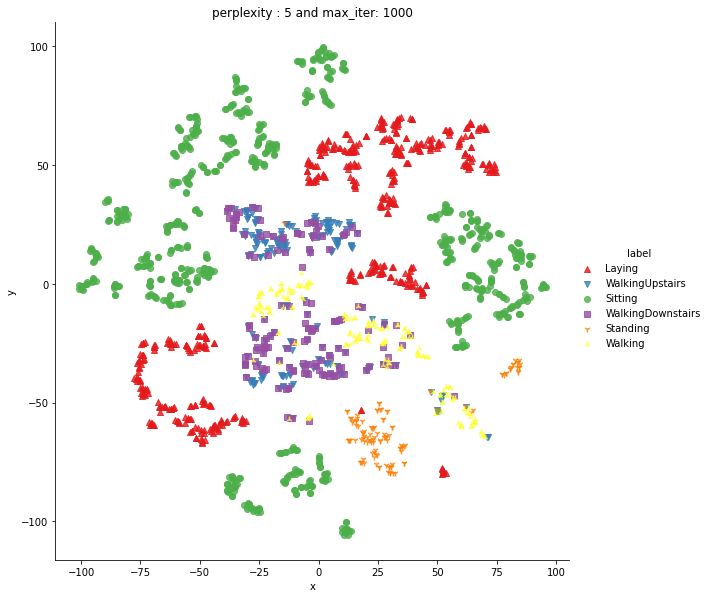

Done

Performing tsne with perplexity 10 and with 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1880 samples in 0.001s...
[t-SNE] Computed neighbors for 1880 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1880
[t-SNE] Computed conditional probabilities for sample 1880 / 1880
[t-SNE] Mean sigma: 2.052115
[t-SNE] Computed conditional probabilities in 0.065s
[t-SNE] Iteration 50: error = 81.9146881, gradient norm = 0.1660064 (50 iterations in 0.988s)
[t-SNE] Iteration 100: error = 69.4144287, gradient norm = 0.0866128 (50 iterations in 0.706s)
[t-SNE] Iteration 150: error = 65.9061279, gradient norm = 0.0711771 (50 iterations in 0.660s)
[t-SNE] Iteration 200: error = 64.2244186, gradient norm = 0.0618407 (50 iterations in 0.679s)
[t-SNE] Iteration 250: error = 63.1974487, gradient norm = 0.0602170 (50 iterations in 0.664s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.197449
[t-SNE] Iteration 30

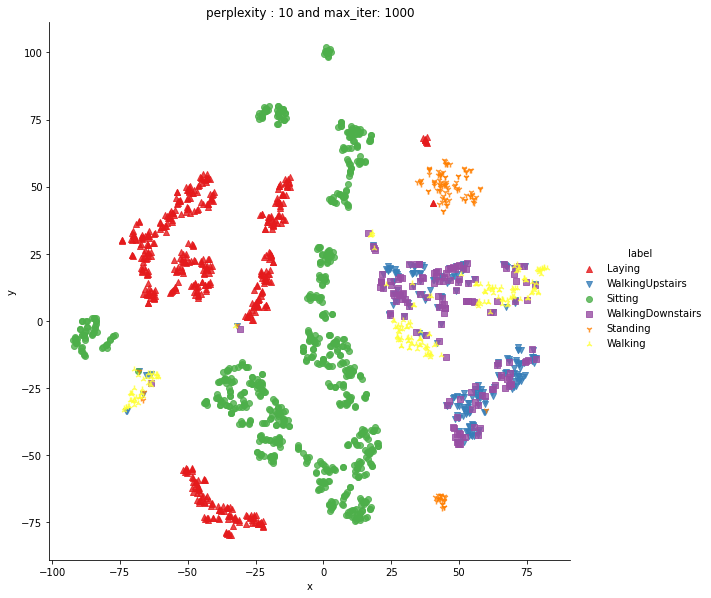

Done

Performing tsne with perplexity 20 and with 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1880 samples in 0.000s...
[t-SNE] Computed neighbors for 1880 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1880
[t-SNE] Computed conditional probabilities for sample 1880 / 1880
[t-SNE] Mean sigma: 2.632443
[t-SNE] Computed conditional probabilities in 0.125s
[t-SNE] Iteration 50: error = 73.1273346, gradient norm = 0.1422976 (50 iterations in 0.974s)
[t-SNE] Iteration 100: error = 61.3826065, gradient norm = 0.0583954 (50 iterations in 0.777s)
[t-SNE] Iteration 150: error = 58.8285408, gradient norm = 0.0508356 (50 iterations in 0.729s)
[t-SNE] Iteration 200: error = 57.5901146, gradient norm = 0.0349964 (50 iterations in 0.774s)
[t-SNE] Iteration 250: error = 56.8734932, gradient norm = 0.0306605 (50 iterations in 0.737s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.873493
[t-SNE] Iteration 30

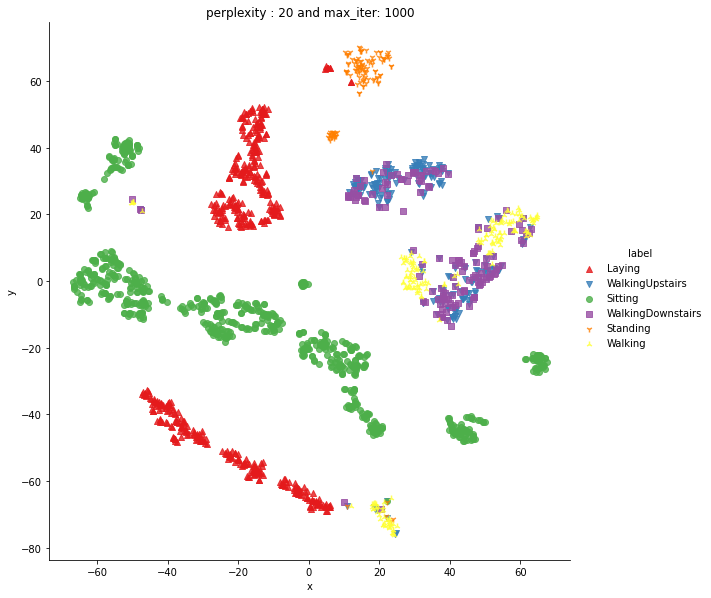

Done


In [12]:
perform_tsne(X_data = og_X_train, y_data = og_y_train, perplexities = [5,10,20], markers = ['^', 'v', 'o', 's', '1', '2'])

## t-sne for New DataSet


Performing tsne with perplexity 5 and with 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3138 samples in 0.002s...
[t-SNE] Computed neighbors for 3138 samples in 0.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3138
[t-SNE] Computed conditional probabilities for sample 2000 / 3138
[t-SNE] Computed conditional probabilities for sample 3000 / 3138
[t-SNE] Computed conditional probabilities for sample 3138 / 3138
[t-SNE] Mean sigma: 5.409100
[t-SNE] Computed conditional probabilities in 0.067s
[t-SNE] Iteration 50: error = 103.6381378, gradient norm = 0.0624614 (50 iterations in 1.919s)
[t-SNE] Iteration 100: error = 88.1573792, gradient norm = 0.0518566 (50 iterations in 1.350s)
[t-SNE] Iteration 150: error = 84.1625443, gradient norm = 0.0313195 (50 iterations in 1.218s)
[t-SNE] Iteration 200: error = 82.2637329, gradient norm = 0.0211746 (50 iterations in 1.169s)
[t-SNE] Iteration 250: error = 81.0956879, gradient norm = 0.01567

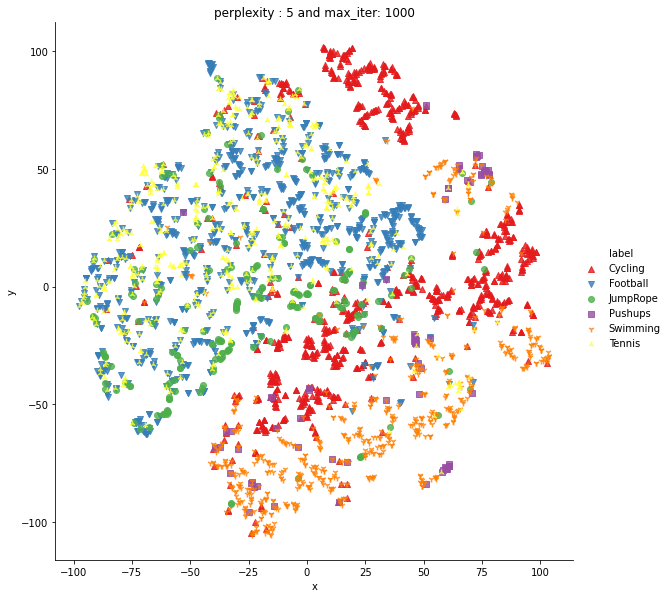

Done

Performing tsne with perplexity 10 and with 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3138 samples in 0.002s...
[t-SNE] Computed neighbors for 3138 samples in 0.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3138
[t-SNE] Computed conditional probabilities for sample 2000 / 3138
[t-SNE] Computed conditional probabilities for sample 3000 / 3138
[t-SNE] Computed conditional probabilities for sample 3138 / 3138
[t-SNE] Mean sigma: 6.639595
[t-SNE] Computed conditional probabilities in 0.158s
[t-SNE] Iteration 50: error = 94.1260071, gradient norm = 0.0839722 (50 iterations in 1.675s)
[t-SNE] Iteration 100: error = 79.8716125, gradient norm = 0.0354211 (50 iterations in 1.214s)
[t-SNE] Iteration 150: error = 77.4703445, gradient norm = 0.0178783 (50 iterations in 1.143s)
[t-SNE] Iteration 200: error = 76.5967407, gradient norm = 0.0070747 (50 iterations in 1.136s)
[t-SNE] Iteration 250: error = 76.1581802, gradient norm = 0.

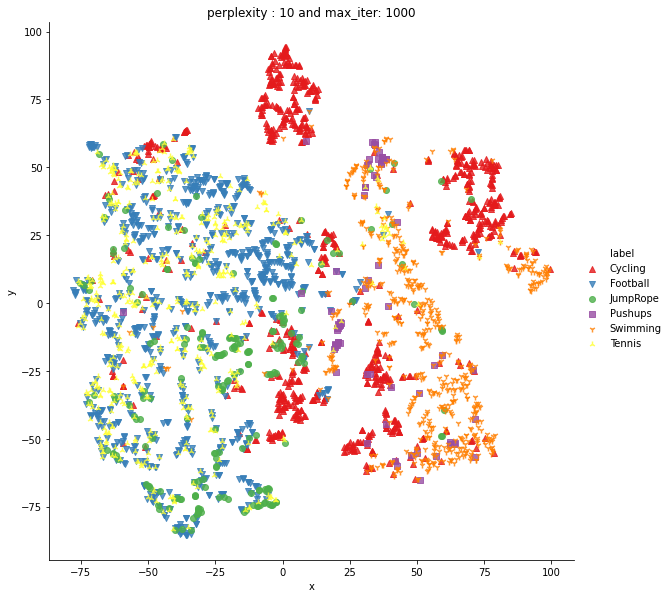

Done

Performing tsne with perplexity 20 and with 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3138 samples in 0.000s...
[t-SNE] Computed neighbors for 3138 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3138
[t-SNE] Computed conditional probabilities for sample 2000 / 3138
[t-SNE] Computed conditional probabilities for sample 3000 / 3138
[t-SNE] Computed conditional probabilities for sample 3138 / 3138
[t-SNE] Mean sigma: 7.718584
[t-SNE] Computed conditional probabilities in 0.284s
[t-SNE] Iteration 50: error = 85.1353455, gradient norm = 0.0787532 (50 iterations in 2.402s)
[t-SNE] Iteration 100: error = 73.4383621, gradient norm = 0.0146056 (50 iterations in 1.499s)
[t-SNE] Iteration 150: error = 72.0703659, gradient norm = 0.0085088 (50 iterations in 1.456s)
[t-SNE] Iteration 200: error = 71.5689926, gradient norm = 0.0066203 (50 iterations in 1.478s)
[t-SNE] Iteration 250: error = 71.1703796, gradient norm = 0.

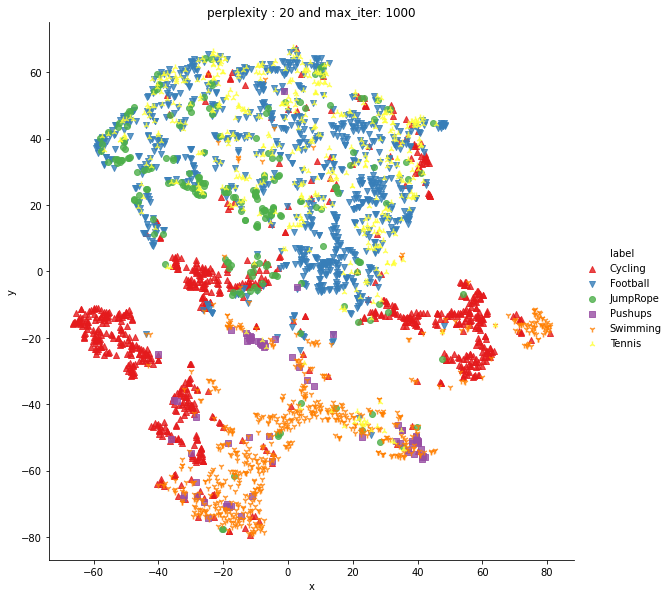

Done


In [13]:
perform_tsne(X_data = new_X_train, y_data = new_y_train, perplexities = [5,10,20], markers = ['^', 'v', 'o', 's', '1', '2'])

## Modelling Data

In [14]:
import matplotlib.colors as colors

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

### Setting up Confusion Matrix

In [15]:
# function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

### Performing Model

In [16]:
# generic function to run any model specified
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, print_cm=True, cm_map=plt.cm.Greens):
    # to store results at various phases
    results = dict()
    
    # time at which model starts training
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print("Done\n\n")
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done\n\n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing_time(HH:MM:SS.ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('-----------------------')
    print('|       Accuracy      |')
    print('-----------------------')
    print('\n      {}\n\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('-----------------------')
        print('|   Confusion Matrix  |')
        print('-----------------------')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap=cm_map)
    plt.show()
    
    # get classification report
    print('-----------------------------')
    print('|   Classification Report   |')
    print('-----------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results

### Determine Best Parameters from GridSearch

In [17]:
# function to print the gridsearch Attributes
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('-----------------------')
    print('|    Best Estimator   |')
    print('-----------------------')
    print('\n\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while performing grid search
    print('-----------------------')
    print('|   Best Parameters   |')
    print('-----------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))
    
    # number of cross validation splits
    print('--------------------------------')
    print('|  No of CrossValidation sets  |')
    print('--------------------------------')
    print('\n\tTotal number of cross validation sets: {}\n'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('-----------------------')
    print('|      Best Score     |')
    print('-----------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

## Predicting Activities

### Importing Different Models

In [18]:
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn import tree

## Support Vector Machines

### Radial Basis Function

Original DataSet
training the model..
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done


training_time(HH:MM:SS.ms) - 0:00:21.828005


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.125686


-----------------------
|       Accuracy      |
-----------------------

      0.9442379182156134


-----------------------
|   Confusion Matrix  |
-----------------------

 [[215   0   1   0   0   0]
 [  0 307   0   2   0   0]
 [  0   0  46   1   0   0]
 [  0   0   0  93   1   0]
 [  0   0   0   5  37  20]
 [  0   0   0   2  13  64]]


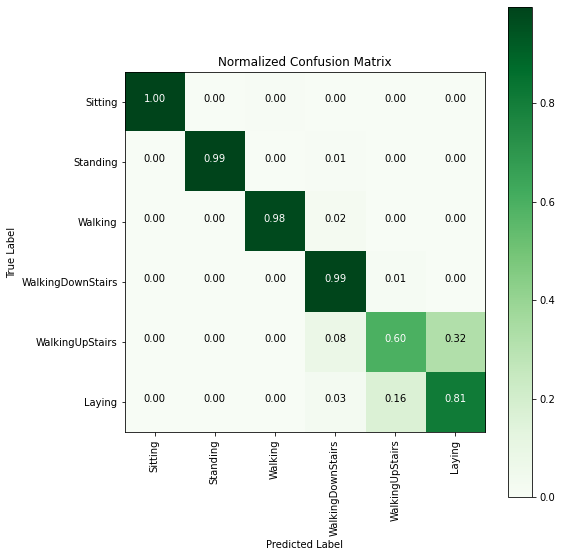

-----------------------------
|   Classification Report   |
-----------------------------
                   precision    recall  f1-score   support

           Laying       1.00      1.00      1.00       216
          Sitting       1.00      0.99      1.00       309
         Standing       0.98      0.98      0.98        47
          Walking       0.90      0.99      0.94        94
WalkingDownstairs       0.73      0.60      0.65        62
  WalkingUpstairs       0.76      0.81      0.79        79

         accuracy                           0.94       807
        macro avg       0.89      0.89      0.89       807
     weighted avg       0.94      0.94      0.94       807


New DataSet
training the model..
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done


training_time(HH:MM:SS.ms) - 0:01:38.215549


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.768479


-----------------------
|       Accuracy      |
-----------------------

      0.76894502228826

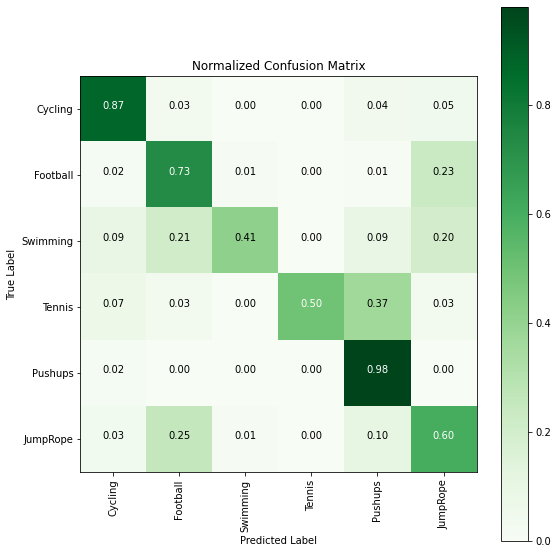

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.90      0.87      0.89       300
    Football       0.77      0.73      0.75       402
    JumpRope       0.84      0.41      0.55        87
     Pushups       0.88      0.50      0.64        30
    Swimming       0.83      0.98      0.90       295
      Tennis       0.52      0.60      0.56       232

    accuracy                           0.77      1346
   macro avg       0.79      0.68      0.71      1346
weighted avg       0.78      0.77      0.77      1346



In [19]:
rbf_kernel = svm.SVC(kernel='rbf')
rbf_params = {'C':[55, 60, 65, 81, 90], 'gamma':['scale', 0.01, 0.03, 0.05, 0.07]}
rbf_svc_grid = GridSearchCV(rbf_kernel, param_grid=rbf_params, n_jobs=-1, verbose=1)
print("Original DataSet")
og_rbf_svc_grid_results = perform_model(rbf_svc_grid, og_X_train, og_y_train, og_X_test, og_y_test,class_labels=og_labels)
print("\nNew DataSet")
new_rbf_svc_grid_results = perform_model(rbf_svc_grid, new_X_train, new_y_train, new_X_test, new_y_test,class_labels=new_labels)

In [20]:
print("Original DataSet")
print_grid_search_attributes(og_rbf_svc_grid_results['model'])
print("\nNew DataSet")
print_grid_search_attributes(new_rbf_svc_grid_results['model'])

Original DataSet
-----------------------
|    Best Estimator   |
-----------------------

	SVC(C=90)

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 90, 'gamma': 'scale'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.7883963672934508


New DataSet
-----------------------
|    Best Estimator   |
-----------------------

	SVC(C=90)

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 90, 'gamma': 'scale'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validat

### Polynomial

Original DataSet
training the model..
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done


training_time(HH:MM:SS.ms) - 0:00:04.726489


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.079171


-----------------------
|       Accuracy      |
-----------------------

      0.9454770755885997


-----------------------
|   Confusion Matrix  |
-----------------------

 [[215   0   1   0   0   0]
 [  0 307   0   2   0   0]
 [  0   0  46   1   0   0]
 [  0   0   0  92   2   0]
 [  0   0   0   5  39  18]
 [  0   0   0   2  13  64]]


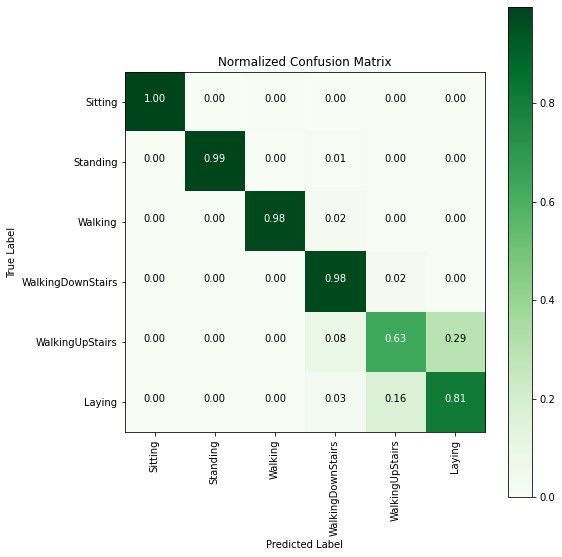

-----------------------------
|   Classification Report   |
-----------------------------
                   precision    recall  f1-score   support

           Laying       1.00      1.00      1.00       216
          Sitting       1.00      0.99      1.00       309
         Standing       0.98      0.98      0.98        47
          Walking       0.90      0.98      0.94        94
WalkingDownstairs       0.72      0.63      0.67        62
  WalkingUpstairs       0.78      0.81      0.80        79

         accuracy                           0.95       807
        macro avg       0.90      0.90      0.90       807
     weighted avg       0.94      0.95      0.94       807


New DataSet
training the model..
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done


training_time(HH:MM:SS.ms) - 0:01:06.435344


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.286163


-----------------------
|       Accuracy      |
-----------------------

      0.74814264487369

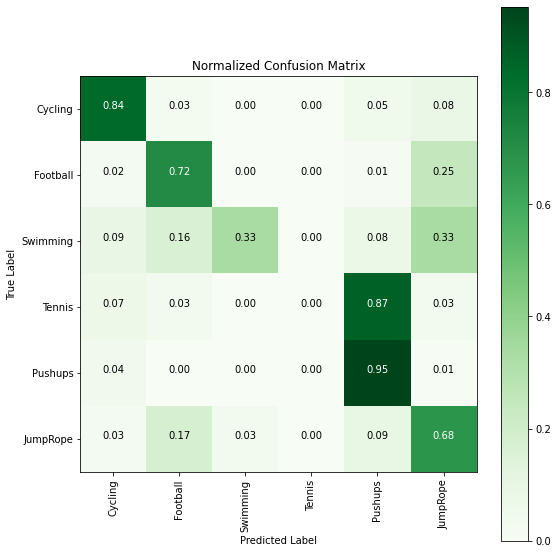

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.87      0.84      0.85       300
    Football       0.82      0.72      0.76       402
    JumpRope       0.78      0.33      0.47        87
     Pushups       0.00      0.00      0.00        30
    Swimming       0.79      0.95      0.86       295
      Tennis       0.50      0.68      0.58       232

    accuracy                           0.75      1346
   macro avg       0.63      0.59      0.59      1346
weighted avg       0.75      0.75      0.74      1346



In [21]:
poly_kernel = svm.SVC(kernel='poly')
poly_params = {'C':[0.125, 0.5, 1, 2, 8, 16], 'degree': [1, 2, 3, 4, 5]}
poly_svc_grid = GridSearchCV(poly_kernel, param_grid=poly_params, n_jobs=-1, verbose=1)
print("Original DataSet")
og_poly_svc_grid_results = perform_model(poly_svc_grid, og_X_train, og_y_train, og_X_test, og_y_test,class_labels=og_labels)
print("\nNew DataSet")
new_poly_svc_grid_results = perform_model(poly_svc_grid, new_X_train, new_y_train, new_X_test, new_y_test,class_labels=new_labels)

In [22]:
print("Original DataSet")
print_grid_search_attributes(og_poly_svc_grid_results['model'])
print("\nNew DataSet")
print_grid_search_attributes(new_poly_svc_grid_results['model'])

Original DataSet
-----------------------
|    Best Estimator   |
-----------------------

	SVC(C=16, degree=1, kernel='poly')

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 16, 'degree': 1}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.7667235546886905


New DataSet
-----------------------
|    Best Estimator   |
-----------------------

	SVC(C=16, degree=1, kernel='poly')

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 16, 'degree': 1}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-------

## K-Nearest Neighbours

Original DataSet
training the model..
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done


training_time(HH:MM:SS.ms) - 0:00:04.347355


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.309108


-----------------------
|       Accuracy      |
-----------------------

      0.9144981412639405


-----------------------
|   Confusion Matrix  |
-----------------------

 [[215   0   1   0   0   0]
 [  0 307   0   2   0   0]
 [  0   0  46   1   0   0]
 [  0   0   0  86   4   4]
 [  1   0   0   8  25  28]
 [  0   0   0   5  15  59]]


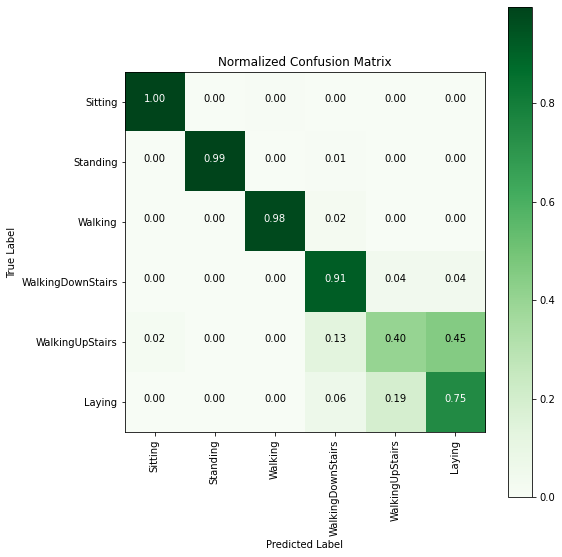

-----------------------------
|   Classification Report   |
-----------------------------
                   precision    recall  f1-score   support

           Laying       1.00      1.00      1.00       216
          Sitting       1.00      0.99      1.00       309
         Standing       0.98      0.98      0.98        47
          Walking       0.84      0.91      0.88        94
WalkingDownstairs       0.57      0.40      0.47        62
  WalkingUpstairs       0.65      0.75      0.69        79

         accuracy                           0.91       807
        macro avg       0.84      0.84      0.84       807
     weighted avg       0.91      0.91      0.91       807


New DataSet
training the model..
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done


training_time(HH:MM:SS.ms) - 0:00:11.952337


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:01.060078


-----------------------
|       Accuracy      |
-----------------------

      0.73699851411589

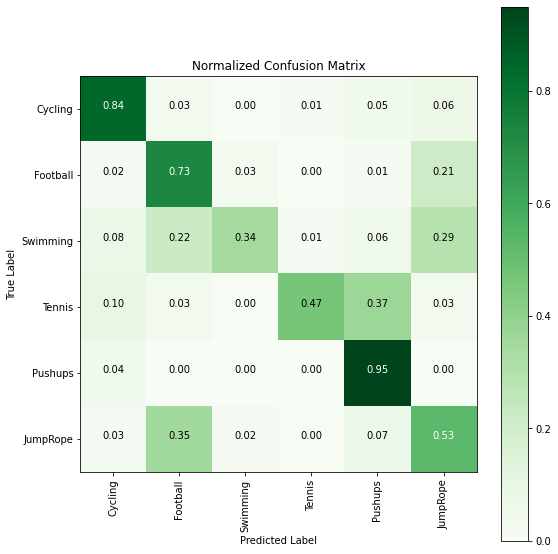

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.87      0.84      0.86       300
    Football       0.72      0.73      0.73       402
    JumpRope       0.62      0.34      0.44        87
     Pushups       0.70      0.47      0.56        30
    Swimming       0.84      0.95      0.89       295
      Tennis       0.49      0.53      0.51       232

    accuracy                           0.74      1346
   macro avg       0.71      0.64      0.66      1346
weighted avg       0.74      0.74      0.73      1346



In [23]:
knn_params = {'n_neighbors':[7, 9, 11, 13, 17], 'weights': ['uniform','distance'], 'algorithm': ['ball_tree', 'kd_tree','brute']}
knn_kernel = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(knn_kernel, param_grid=knn_params, n_jobs=-1, verbose=1)
print("Original DataSet")
og_knn_grid_results = perform_model(knn_grid, og_X_train, og_y_train, og_X_test, og_y_test,class_labels=og_labels)
print("\nNew DataSet")
new_knn_grid_results = perform_model(knn_grid, new_X_train, new_y_train, new_X_test, new_y_test,class_labels=new_labels)

In [24]:
print("Original DataSet")
print_grid_search_attributes(og_knn_grid_results['model'])
print("\nNew DataSet")
print_grid_search_attributes(new_knn_grid_results['model'])

Original DataSet
-----------------------
|    Best Estimator   |
-----------------------

	KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.7351730513312813


New DataSet
-----------------------
|    Best Estimator   |
-----------------------

	KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}

--------------------

## Logistic Regression

Original DataSet
training the model..
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Done


training_time(HH:MM:SS.ms) - 0:06:03.801123


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.016812


-----------------------
|       Accuracy      |
-----------------------

      0.9467162329615861


-----------------------
|   Confusion Matrix  |
-----------------------

 [[215   0   1   0   0   0]
 [  0 307   0   2   0   0]
 [  0   0  46   1   0   0]
 [  0   0   0  93   1   0]
 [  0   0   1   4  37  20]
 [  0   0   0   0  13  66]]


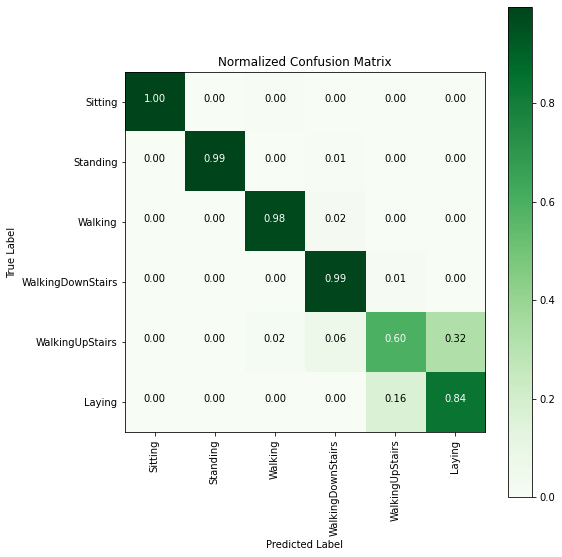

-----------------------------
|   Classification Report   |
-----------------------------
                   precision    recall  f1-score   support

           Laying       1.00      1.00      1.00       216
          Sitting       1.00      0.99      1.00       309
         Standing       0.96      0.98      0.97        47
          Walking       0.93      0.99      0.96        94
WalkingDownstairs       0.73      0.60      0.65        62
  WalkingUpstairs       0.77      0.84      0.80        79

         accuracy                           0.95       807
        macro avg       0.90      0.90      0.90       807
     weighted avg       0.95      0.95      0.95       807


New DataSet
training the model..
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Done


training_time(HH:MM:SS.ms) - 0:18:28.587620


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00


-----------------------
|       Accuracy      |
-----------------------

      0.7800891530460624


-

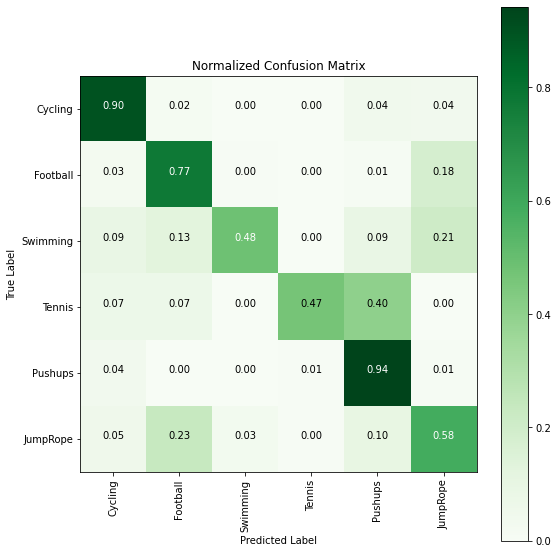

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.86      0.90      0.88       300
    Football       0.81      0.77      0.79       402
    JumpRope       0.82      0.48      0.61        87
     Pushups       0.78      0.47      0.58        30
    Swimming       0.82      0.94      0.88       295
      Tennis       0.56      0.58      0.57       232

    accuracy                           0.78      1346
   macro avg       0.78      0.69      0.72      1346
weighted avg       0.78      0.78      0.78      1346



In [25]:
reg_params = {'C':[0.001, 0.125, 0.5, 1, 8, 16, 50], 'class_weight':['balanced',None], 
              'solver':[ 'newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class':['ovr', 'multinomial']}
reg_kernel = linear_model.LogisticRegression()
reg_grid = GridSearchCV(reg_kernel, param_grid=reg_params, n_jobs=-1, verbose=1)
print("Original DataSet")
og_reg_grid_results = perform_model(reg_grid, og_X_train, og_y_train, og_X_test, og_y_test,class_labels=og_labels)
print("\nNew DataSet")
new_reg_grid_results = perform_model(reg_grid, new_X_train, new_y_train, new_X_test, new_y_test,class_labels=new_labels)

In [26]:
print("Original DataSet")
print_grid_search_attributes(og_reg_grid_results['model'])
print("\nNew DataSet")
print_grid_search_attributes(new_reg_grid_results['model'])

Original DataSet
-----------------------
|    Best Estimator   |
-----------------------

	LogisticRegression(C=0.125, multi_class='ovr')

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 0.125, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'lbfgs'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.7842547161186115


New DataSet
-----------------------
|    Best Estimator   |
-----------------------

	LogisticRegression(C=0.125, multi_class='ovr')

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 0.125, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'lbfgs'}

--------------------------------
|  No of CrossValidation sets  |
--

## Decision Trees

Original DataSet
training the model..
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Done


training_time(HH:MM:SS.ms) - 0:00:04.341267


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.007800


-----------------------
|       Accuracy      |
-----------------------

      0.9281288723667905


-----------------------
|   Confusion Matrix  |
-----------------------

 [[215   0   1   0   0   0]
 [  0 306   0   2   0   1]
 [  0   0  46   1   0   0]
 [  0   0   0  88   3   3]
 [  0   1   0   3  31  27]
 [  0   0   0   1  15  63]]


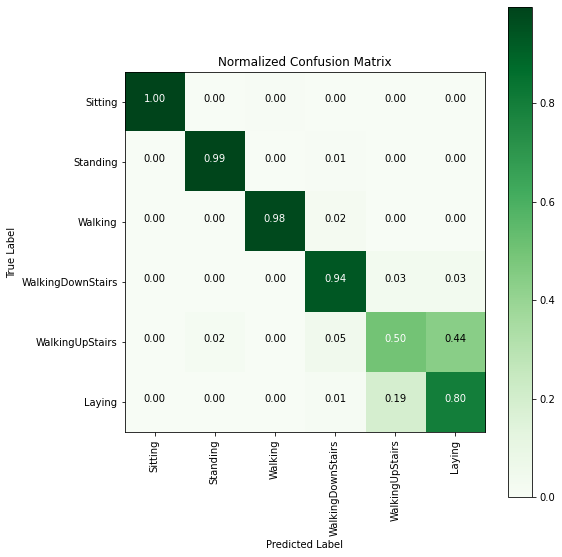

-----------------------------
|   Classification Report   |
-----------------------------
                   precision    recall  f1-score   support

           Laying       1.00      1.00      1.00       216
          Sitting       1.00      0.99      0.99       309
         Standing       0.98      0.98      0.98        47
          Walking       0.93      0.94      0.93        94
WalkingDownstairs       0.63      0.50      0.56        62
  WalkingUpstairs       0.67      0.80      0.73        79

         accuracy                           0.93       807
        macro avg       0.87      0.87      0.86       807
     weighted avg       0.93      0.93      0.93       807


New DataSet
training the model..
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Done


training_time(HH:MM:SS.ms) - 0:00:11.960026


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.015629


-----------------------
|       Accuracy      |
-----------------------

      0.76151560178306

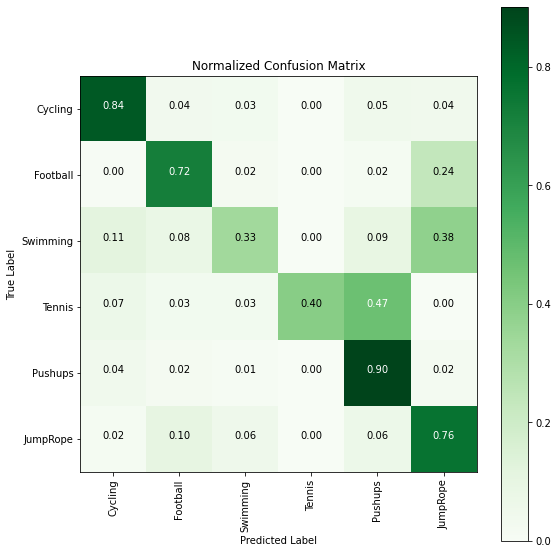

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.89      0.84      0.87       300
    Football       0.86      0.72      0.78       402
    JumpRope       0.45      0.33      0.38        87
     Pushups       0.86      0.40      0.55        30
    Swimming       0.82      0.90      0.86       295
      Tennis       0.54      0.76      0.64       232

    accuracy                           0.76      1346
   macro avg       0.74      0.66      0.68      1346
weighted avg       0.78      0.76      0.76      1346



In [27]:
dt_params = {'max_depth':[3, 5, 7, 9], 'splitter': ['best','random'], 'criterion': ['gini', 'entropy'], 'class_weight':['balanced',None]}
dt_kernel = tree.DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_kernel, param_grid=dt_params, n_jobs=-1, verbose=1)
print("Original DataSet")
og_dt_grid_results = perform_model(dt_grid, og_X_train, og_y_train, og_X_test, og_y_test,class_labels=og_labels)
print("\nNew DataSet")
new_dt_grid_results = perform_model(dt_grid, new_X_train, new_y_train, new_X_test, new_y_test,class_labels=new_labels)

In [28]:
print("Original DataSet")
print_grid_search_attributes(og_dt_grid_results['model'])
print("\nNew DataSet")
print_grid_search_attributes(new_dt_grid_results['model'])

Original DataSet
-----------------------
|    Best Estimator   |
-----------------------

	DecisionTreeClassifier(criterion='entropy', max_depth=5)

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.7673559260049371


New DataSet
-----------------------
|    Best Estimator   |
-----------------------

	DecisionTreeClassifier(criterion='entropy', max_depth=5)

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}

--------------------------------
|